# “火炬上的深度学习"第一次大作业

在这个作业中，你需要半独立地利用人工神经网络搭建一个手写数字识别器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [1]:

"""简单的 LeNet-5类型的卷积神经网络模型，MNIST例子.
"""

#所有依赖包

import gzip
import os
import sys

import numpy as np
from six.moves import urllib
import torch
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pylab as plt

#定义一系列常数
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/' #图像数据如果没下载，可以从这个地址下载
WORK_DIRECTORY = 'data' #存储的路径名
IMAGE_SIZE = 28 #每张图片的大小尺寸
NUM_CHANNELS = 1  #每张图片的通道数
PIXEL_DEPTH = 255 #像素的深度0-255
NUM_LABELS = 10 #手写数字，一共十种

%matplotlib inline



# 读取MINST图形文件

In [2]:
#下载图像文件，如果文件已经存在，那么就不下载。
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.isdir(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        size = os.path.getsize(filepath)
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

def extract_data(filename, num_images):
    # filename: 文件存放的路径，num_images: 读入的图片个数
    """将图像解压缩展开，读入成一个4维的张量： [image index（图像的编码）, y（纵坐标）, x（横坐标）, channels（通道）].
    我们将数组中的数值范围从原来的[0, 255]降低到了[-0.5, 0.5]范围内
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return data

def extract_labels(filename, num_images):
    """将label的数据文件解压缩，并将label读成64位的整数"""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

# 将数据解压缩并存储到数组中，60000张图片，60000个label，测试集中有10000张图片
train_data = extract_data(train_data_filename, 60000)
train_X = train_data.reshape(len(train_data), -1)
train_labels = extract_labels(train_labels_filename, 60000)
train_Y = train_labels
test_data = extract_data(test_data_filename, 10000)
test_X = test_data.reshape(len(test_data), -1)

test_labels = extract_labels(test_labels_filename, 10000)
test_Y = test_labels
train_X.shape, train_Y.shape

# train_X, train_Y 中分别存储的是向量化的训练数据与标签
# test_X, test_Y 中分别存储的是向量化的测试数据与标签
# train_X的维度是60000个样本，784个分量的图像向量
# test_X的维度是10000个样本，784个分量的图像向量

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


((60000, 784), (60000,))

# 在这里写下你自己的代码

### 第一步：定义神经网络，提示，可以使用简单的torch.nn.SequentialModel

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [60]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
    torch.nn.Linear(784, 196),
    torch.nn.Sigmoid(),
    torch.nn.Linear(196, 28),
    torch.nn.Sigmoid(),
    torch.nn.Linear(28, 10),
    torch.nn.Sigmoid(),
    torch.nn.LogSoftmax()
)

# 问题：如果要增加新的神经网络层怎么办？


### 第二步：构造损失函数和优化器

In [61]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

### 第三步：开始训练循环

In [62]:
def error_rate(predictions_raw, labels_raw):
    predictions = np.argmax(predictions_raw.data.numpy(), axis=1)
    labels = labels_raw.data.numpy()
    equals = np.sum(predictions == labels)
    acc = equals / float(predictions.shape[0])
    err = 1.0 - acc
    return err

In [63]:
# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环
losses = []
errors = []

# 神经网络训练循环
batch_size = 128
for i in range(1000):
#   每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取 
    batch_loss = []
    batch_error = []
#   start和end分别是提取一个batch数据的起始和终止下标 
    for start in range(0, len(train_X), batch_size):
        end = (start + batch_size) if (start + batch_size) < len(train_X) else len(train_X)
        xx = Variable(torch.FloatTensor(train_X[start:end])) #从训练数据train_X中提取数据 
        yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
        predict = net(xx) #用神经网络进行预测 
        loss = cost(predict, yy) #计算损失函数（交叉熵） 
        optimizer.zero_grad() #清空梯度 
        loss.backward() #开始反向传播 
        optimizer.step() #开始更新梯度 
        
        # add loss & error rate of this batch
        batch_loss.append(loss.data.numpy())
        batch_error.append(error_rate(predict, yy))
        
    # append loss and error
    losses.append(np.mean(batch_loss))
    errors.append(np.mean(batch_error))
        
#  每隔100步输出一下损失值（loss） 
    if i % 100==0:
        print(i, np.mean(batch_loss), np.mean(batch_error))


0 2.30169 0.892790511727
100 1.5745 0.232953535892
200 1.52421 0.0836387260128
300 1.49624 0.0341762171286
400 1.48595 0.0240927061123
500 1.48021 0.0181458777541
600 1.47654 0.014397876688
700 1.47408 0.0120491293532
800 1.47229 0.0103833511016
900 1.47085 0.00911735963042


### 请在这里写下你自己的回答

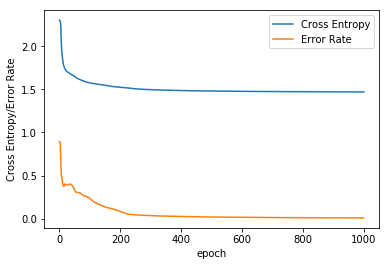

In [64]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！

plt.plot(np.arange(len(losses)), losses, label='Cross Entropy')
plt.plot(np.arange(len(errors)), errors, label='Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error Rate')
plt.legend()
plt.show()

In [90]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
    torch.nn.Linear(784, 196),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(196, 28),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(28, 10),
    torch.nn.LeakyReLU(),
    torch.nn.LogSoftmax()
)

# 问题：如果要增加新的神经网络层怎么办？


In [91]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net.parameters()) #SGD(net.parameters(), lr = 0.1)

In [92]:
def error_rate(predictions_raw, labels_raw):
    predictions = np.argmax(predictions_raw.data.numpy(), axis=1)
    labels = labels_raw.data.numpy()
    equals = np.sum(predictions == labels)
    acc = equals / float(predictions.shape[0])
    err = 1.0 - acc
    return err

In [93]:
# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环
losses = []
errors = []

# 神经网络训练循环
batch_size = 128
for i in range(1000):
#   每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取 
    batch_loss = []
    batch_error = []
#   start和end分别是提取一个batch数据的起始和终止下标 
    for start in range(0, len(train_X), batch_size):
        end = (start + batch_size) if (start + batch_size) < len(train_X) else len(train_X)
        xx = Variable(torch.FloatTensor(train_X[start:end])) #从训练数据train_X中提取数据 
        yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
        predict = net(xx) #用神经网络进行预测 
        loss = cost(predict, yy) #计算损失函数（交叉熵） 
        optimizer.zero_grad() #清空梯度 
        loss.backward() #开始反向传播 
        optimizer.step() #开始更新梯度 
        
        # add loss & error rate of this batch
        batch_loss.append(loss.data.numpy())
        batch_error.append(error_rate(predict, yy))
        
    # append loss and error
    losses.append(np.mean(batch_loss))
    errors.append(np.mean(batch_error))
        
#  每隔100步输出一下损失值（loss） 
    if i % 100==0:
        print(i, np.mean(batch_loss), np.mean(batch_error))


0 0.523072 0.157982409382
100 0.019739 0.00383684257285
200 0.00740951 0.000671863894812
300 0.00410279 0.000372023809524
400 0.00275819 0.000338708244492
500 0.00210723 0.000322050461976
600 0.00175104 0.00030539267946
700 0.00152276 0.00030539267946
800 0.00129579 0.000288734896944
900 0.00118508 0.000288734896944


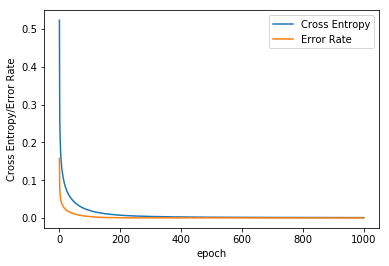

In [94]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！

plt.plot(np.arange(len(losses)), losses, label='Cross Entropy')
plt.plot(np.arange(len(errors)), errors, label='Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error Rate')
plt.legend()
plt.show()

In [95]:
# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = (start + batch_size) if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions, y)
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%' % (np.mean(errors)*100))

1 0.0198
2 0.0199554294976
3 0.0200123152709
4 0.0198627287854
5 0.0198145025295
6 0.0196581196581
7 0.0196057192374
8 0.0197715289982
9 0.0194964349376
10 0.0195524412297
11 0.0191513761468
12 0.0189711359404
13 0.0189035916824
14 0.0189539347409
15 0.0188840155945
16 0.0186881188119
17 0.0181086519115
18 0.0176380368098
19 0.0174116424116
20 0.0170454545455
21 0.0172043010753
22 0.0168216630197
23 0.0169821826281
24 0.0165816326531
25 0.0165993071594
26 0.0166176470588
27 0.0169364508393
28 0.0169621026895
29 0.0165211970075
30 0.0165394402036
31 0.0157467532468
32 0.0155835543767
33 0.015243902439
34 0.0145429362881
35 0.0143413597734
36 0.0144927536232
37 0.0135385756677
38 0.0136778115502
39 0.0128504672897
40 0.0119808306709
41 0.0120901639344
42 0.0119949494949
43 0.0118944636678
44 0.0120106761566
45 0.0121336996337
46 0.0115566037736
47 0.0119163424125
48 0.0107931726908
49 0.010632780083
50 0.0107296137339
51 0.0111111111111
52 0.0115207373272
53 0.00956937799043
54 0.0093283

In [96]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
    torch.nn.Linear(784, 196),
    torch.nn.Tanh(),
    torch.nn.Linear(196, 28),
    torch.nn.Tanh(),
    torch.nn.Linear(28, 10),
    torch.nn.Tanh(),
    torch.nn.LogSoftmax()
)

# 问题：如果要增加新的神经网络层怎么办？


In [97]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net.parameters()) #SGD(net.parameters(), lr = 0.1)

In [98]:
def error_rate(predictions_raw, labels_raw):
    predictions = np.argmax(predictions_raw.data.numpy(), axis=1)
    labels = labels_raw.data.numpy()
    equals = np.sum(predictions == labels)
    acc = equals / float(predictions.shape[0])
    err = 1.0 - acc
    return err

In [99]:
# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环
losses = []
errors = []

# 神经网络训练循环
batch_size = 128
for i in range(1000):
#   每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取 
    batch_loss = []
    batch_error = []
#   start和end分别是提取一个batch数据的起始和终止下标 
    for start in range(0, len(train_X), batch_size):
        end = (start + batch_size) if (start + batch_size) < len(train_X) else len(train_X)
        xx = Variable(torch.FloatTensor(train_X[start:end])) #从训练数据train_X中提取数据 
        yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
        predict = net(xx) #用神经网络进行预测 
        loss = cost(predict, yy) #计算损失函数（交叉熵） 
        optimizer.zero_grad() #清空梯度 
        loss.backward() #开始反向传播 
        optimizer.step() #开始更新梯度 
        
        # add loss & error rate of this batch
        batch_loss.append(loss.data.numpy())
        batch_error.append(error_rate(predict, yy))
        
    # append loss and error
    losses.append(np.mean(batch_loss))
    errors.append(np.mean(batch_error))
        
#  每隔100步输出一下损失值（loss） 
    if i % 100==0:
        print(i, np.mean(batch_loss), np.mean(batch_error))


0 1.19356 0.146571828358
100 0.80873 0.0051361496091
200 0.803599 0.00315387348969
300 0.801868 0.0025375355366
400 0.801127 0.00228766879886
500 0.8007 0.00208777540867
600 0.800449 0.00197117093106
700 0.800222 0.00188788201848
800 0.800109 0.00187122423596
900 0.800032 0.00187122423596


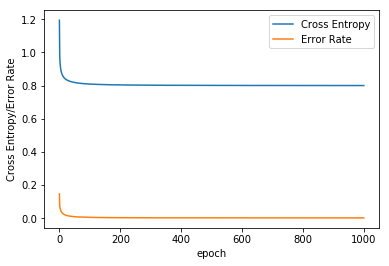

In [100]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！

plt.plot(np.arange(len(losses)), losses, label='Cross Entropy')
plt.plot(np.arange(len(errors)), errors, label='Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error Rate')
plt.legend()
plt.show()

In [101]:
# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = (start + batch_size) if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions, y)
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%' % (np.mean(errors)*100))

1 0.0183
2 0.0184359805511
3 0.0185755336617
4 0.0184068219634
5 0.0183389544688
6 0.0183760683761
7 0.018089254766
8 0.0182337434095
9 0.0180481283422
10 0.0179701627486
11 0.0175458715596
12 0.0173417132216
13 0.0170132325142
14 0.0167946257198
15 0.0162037037037
16 0.0163366336634
17 0.0159708249497
18 0.0153374233129
19 0.0150727650728
20 0.0150634249471
21 0.015188172043
22 0.0151805251641
23 0.0153118040089
24 0.015022675737
25 0.0148672055427
26 0.015
27 0.0151378896882
28 0.0149755501222
29 0.0143391521197
30 0.0144720101781
31 0.0136363636364
32 0.0132625994695
33 0.0132113821138
34 0.012811634349
35 0.0125708215297
36 0.0126811594203
37 0.0124258160237
38 0.0123480243161
39 0.0120716510903
40 0.0117811501597
41 0.0118852459016
42 0.0119949494949
43 0.0121107266436
44 0.0122330960854
45 0.0125915750916
46 0.0120283018868
47 0.0119163424125
48 0.0105421686747
49 0.010632780083
50 0.0107296137339
51 0.0111111111111
52 0.011232718894
53 0.00927033492823
54 0.00901741293532
55 0.0

In [104]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
    torch.nn.Linear(784, 196),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(196, 28),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(28, 10),
    torch.nn.LeakyReLU(),
    torch.nn.LogSoftmax()
)

# 问题：如果要增加新的神经网络层怎么办？


In [105]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters()) #SGD(net.parameters(), lr = 0.1)

In [106]:
def error_rate(predictions_raw, labels_raw):
    predictions = np.argmax(predictions_raw.data.numpy(), axis=1)
    labels = labels_raw.data.numpy()
    equals = np.sum(predictions == labels)
    acc = equals / float(predictions.shape[0])
    err = 1.0 - acc
    return err

In [107]:
# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环
losses = []
errors = []

# 神经网络训练循环
batch_size = 128
for i in range(1000):
#   每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取 
    batch_loss = []
    batch_error = []
#   start和end分别是提取一个batch数据的起始和终止下标 
    for start in range(0, len(train_X), batch_size):
        end = (start + batch_size) if (start + batch_size) < len(train_X) else len(train_X)
        xx = Variable(torch.FloatTensor(train_X[start:end])) #从训练数据train_X中提取数据 
        yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
        predict = net(xx) #用神经网络进行预测 
        loss = cost(predict, yy) #计算损失函数（交叉熵） 
        optimizer.zero_grad() #清空梯度 
        loss.backward() #开始反向传播 
        optimizer.step() #开始更新梯度 
        
        # add loss & error rate of this batch
        batch_loss.append(loss.data.numpy())
        batch_error.append(error_rate(predict, yy))
        
    # append loss and error
    losses.append(np.mean(batch_loss))
    errors.append(np.mean(batch_error))
        
#  每隔100步输出一下损失值（loss） 
    if i % 100==0:
        print(i, np.mean(batch_loss), np.mean(batch_error))


0 0.648851 0.198338663824
100 0.00837005 0.00252087775409
200 0.00644914 0.00150475302061
300 0.00579289 0.00143812189055
400 0.00310663 0.000788468372424
500 0.000127536 3.8868159204e-05
600 0.00283446 0.0005552594172
700 0.00256931 0.00052749644634
800 0.00153441 0.000355366027008
900 1.83602e-11 0.0


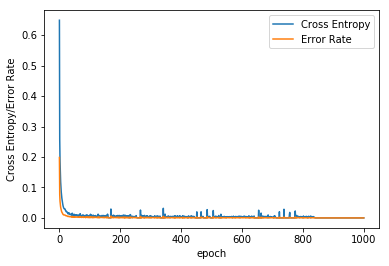

In [108]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！

plt.plot(np.arange(len(losses)), losses, label='Cross Entropy')
plt.plot(np.arange(len(errors)), errors, label='Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error Rate')
plt.legend()
plt.show()

In [109]:
# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = (start + batch_size) if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions, y)
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%' % (np.mean(errors)*100))

1 0.0176
2 0.0176256077796
3 0.0176518883415
4 0.0177828618968
5 0.0178119730185
6 0.0179487179487
7 0.0178726169844
8 0.0179042179262
9 0.0176024955437
10 0.0175180831826
11 0.0169724770642
12 0.0164106145251
13 0.015949905482
14 0.0158349328215
15 0.0154727095517
16 0.0154702970297
17 0.0152162977867
18 0.0148261758691
19 0.0148128898129
20 0.0149312896406
21 0.0149193548387
22 0.0147702407002
23 0.0147550111359
24 0.0141723356009
25 0.013856812933
26 0.0136764705882
27 0.0137889688249
28 0.0132946210269
29 0.0129364089776
30 0.0128816793893
31 0.012987012987
32 0.0127652519894
33 0.0127032520325
34 0.0122922437673
35 0.012216713881
36 0.0119565217391
37 0.0111275964392
38 0.0108282674772
39 0.0103193146417
40 0.00978434504792
41 0.00983606557377
42 0.00989057239057
43 0.0101643598616
44 0.010231316726
45 0.0105311355311
46 0.0103773584906
47 0.0104571984436
48 0.00878514056225
49 0.00907676348548
50 0.00912017167382
51 0.00944444444444
52 0.00979262672811
53 0.00837320574163
54 0.00

In [152]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
    torch.nn.Linear(784, 196),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm1d(196),
    torch.nn.Linear(196, 28),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm1d(28),
    torch.nn.Linear(28, 10),
    torch.nn.LeakyReLU(),
    torch.nn.LogSoftmax()
)

# 问题：如果要增加新的神经网络层怎么办？


In [153]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters()) #SGD(net.parameters(), lr = 0.1)

In [154]:
def error_rate(predictions_raw, labels_raw):
    predictions = np.argmax(predictions_raw.data.numpy(), axis=1)
    labels = labels_raw.data.numpy()
    equals = np.sum(predictions == labels)
    acc = equals / float(predictions.shape[0])
    err = 1.0 - acc
    return err

In [155]:
net.train()

# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环
losses = []
errors = []

# 神经网络训练循环
batch_size = 128
for i in range(1000):
#   每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取 
    batch_loss = []
    batch_error = []
#   start和end分别是提取一个batch数据的起始和终止下标 
    for start in range(0, len(train_X), batch_size):
        end = (start + batch_size) if (start + batch_size) < len(train_X) else len(train_X)
        xx = Variable(torch.FloatTensor(train_X[start:end])) #从训练数据train_X中提取数据 
        yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
        predict = net(xx) #用神经网络进行预测 
        loss = cost(predict, yy) #计算损失函数（交叉熵） 
        optimizer.zero_grad() #清空梯度 
        loss.backward() #开始反向传播 
        optimizer.step() #开始更新梯度 
        
        # add loss & error rate of this batch
        batch_loss.append(loss.data.numpy())
        batch_error.append(error_rate(predict, yy))
        
    # append loss and error
    losses.append(np.mean(batch_loss))
    errors.append(np.mean(batch_error))
        
#  每隔100步输出一下损失值（loss） 
    if i % 100==0:
        print(i, np.mean(batch_loss), np.mean(batch_error))


0 0.594026 0.106626465885
100 0.00078785 0.000116604477612
200 0.000280514 6.6631130064e-05
300 0.000397845 3.3315565032e-05
400 2.86046e-06 0.0
500 1.83116e-10 0.0
600 7.14719e-11 0.0
700 4.40263e-11 0.0
800 3.16721e-11 0.0
900 2.4671e-11 0.0


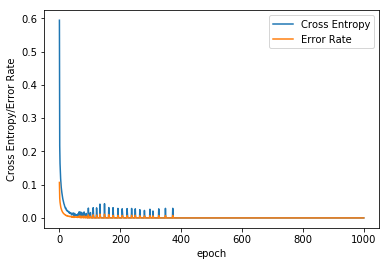

In [156]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！

plt.plot(np.arange(len(losses)), losses, label='Cross Entropy')
plt.plot(np.arange(len(errors)), errors, label='Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error Rate')
plt.legend()
plt.show()

In [157]:
net.eval()

# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = (start + batch_size) if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions, y)
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%' % (np.mean(errors)*100))

1 0.0291
2 0.0291734197731
3 0.0293513957307
4 0.0294301164725
5 0.029194772344
6 0.0291666666667
7 0.0289211438475
8 0.0292179261863
9 0.029077540107
10 0.0289330922242
11 0.0285550458716
12 0.0285148975791
13 0.0281190926276
14 0.0280710172745
15 0.0275341130604
16 0.0274752475248
17 0.0271629778672
18 0.0264570552147
19 0.0261174636175
20 0.025766384778
21 0.0258064516129
22 0.0254376367615
23 0.0256124721604
24 0.0250850340136
25 0.0251154734411
26 0.025
27 0.025329736211
28 0.0252139364303
29 0.024470074813
30 0.0244910941476
31 0.0237012987013
32 0.0230437665782
33 0.0220189701897
34 0.0216412742382
35 0.0212464589235
36 0.020652173913
37 0.0196587537092
38 0.0199468085106
39 0.0192757009346
40 0.0187699680511
41 0.0190573770492
42 0.0193602693603
43 0.0196799307958
44 0.0197953736655
45 0.0199175824176
46 0.0193396226415
47 0.0194552529183
48 0.0183232931727
49 0.018153526971
50 0.018508583691
51 0.0188888888889
52 0.019297235023
53 0.0170454545455
54 0.0167910447761
55 0.017487

In [158]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
    torch.nn.Linear(784, 56),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm1d(56),
    torch.nn.Linear(56, 28),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm1d(28),
    torch.nn.Linear(28, 14),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm1d(14),
    torch.nn.Linear(14, 10),
    torch.nn.LeakyReLU(),
    torch.nn.LogSoftmax()
)

# 问题：如果要增加新的神经网络层怎么办？


In [159]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters()) #SGD(net.parameters(), lr = 0.1)

In [160]:
def error_rate(predictions_raw, labels_raw):
    predictions = np.argmax(predictions_raw.data.numpy(), axis=1)
    labels = labels_raw.data.numpy()
    equals = np.sum(predictions == labels)
    acc = equals / float(predictions.shape[0])
    err = 1.0 - acc
    return err

In [161]:
net.train()

# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环
losses = []
errors = []

# 神经网络训练循环
batch_size = 128
for i in range(1000):
#   每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取 
    batch_loss = []
    batch_error = []
#   start和end分别是提取一个batch数据的起始和终止下标 
    for start in range(0, len(train_X), batch_size):
        end = (start + batch_size) if (start + batch_size) < len(train_X) else len(train_X)
        xx = Variable(torch.FloatTensor(train_X[start:end])) #从训练数据train_X中提取数据 
        yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
        predict = net(xx) #用神经网络进行预测 
        loss = cost(predict, yy) #计算损失函数（交叉熵） 
        optimizer.zero_grad() #清空梯度 
        loss.backward() #开始反向传播 
        optimizer.step() #开始更新梯度 
        
        # add loss & error rate of this batch
        batch_loss.append(loss.data.numpy())
        batch_error.append(error_rate(predict, yy))
        
    # append loss and error
    losses.append(np.mean(batch_loss))
    errors.append(np.mean(batch_error))
        
#  每隔100步输出一下损失值（loss） 
    if i % 100==0:
        print(i, np.mean(batch_loss), np.mean(batch_error))


0 0.846128 0.168815520611
100 0.00617797 0.00173796197584
200 0.00163341 0.000338708244492
300 0.000798552 0.000272077114428
400 0.000666779 0.000255419331912
500 0.00060359 0.00022210376688
600 0.00486476 0.00142146410803
700 0.000632313 0.000205445984364
800 0.000558437 0.000205445984364
900 0.000796609 0.000238761549396


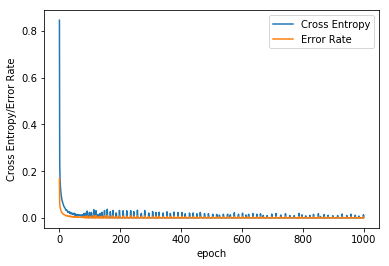

In [162]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！

plt.plot(np.arange(len(losses)), losses, label='Cross Entropy')
plt.plot(np.arange(len(errors)), errors, label='Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error Rate')
plt.legend()
plt.show()

In [163]:
net.eval()

# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = (start + batch_size) if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions, y)
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%' % (np.mean(errors)*100))

1 0.0345
2 0.0346434359806
3 0.0344827586207
4 0.0348377703827
5 0.0348861720067
6 0.0348290598291
7 0.0347703639515
8 0.035039543058
9 0.0347593582888
10 0.0345840867993
11 0.0338302752294
12 0.0336359404097
13 0.0333175803403
14 0.0331094049904
15 0.0326510721248
16 0.0326732673267
17 0.0321931589537
18 0.0316973415133
19 0.0315748440748
20 0.0311839323467
21 0.0311827956989
22 0.0309080962801
23 0.0314587973274
24 0.03089569161
25 0.0310334872979
26 0.0308823529412
27 0.0305755395683
28 0.0308679706601
29 0.0299251870324
30 0.0300572519084
31 0.0290584415584
32 0.028348806366
33 0.0279471544715
34 0.0278739612188
35 0.0276203966006
36 0.0275362318841
37 0.0270771513353
38 0.0269756838906
39 0.0264797507788
40 0.0257587859425
41 0.0258196721311
42 0.0256734006734
43 0.0261678200692
44 0.0266903914591
45 0.0267857142857
46 0.0266509433962
47 0.0267509727626
48 0.0256024096386
49 0.024377593361
50 0.024678111588
51 0.0247222222222
52 0.0253456221198
53 0.0215311004785
54 0.021455223880

In [114]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.act = torch.nn.LeakyReLU()
        self.conv1 = torch.nn.Conv2d(kernel_size=4, in_channels=1, out_channels=5)
        self.conv2 = torch.nn.Conv2d(kernel_size=4, in_channels=5, out_channels=10)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(in_features=10*4*4, out_features=20)
        self.bn = torch.nn.BatchNorm2d(20)
        self.fc2 = torch.nn.Linear(in_features=20, out_features=10)
        
    def forward(self, x):
        x = self.act(self.maxpool(self.conv1(x))) #1x28x28 -> 20x25x25 -> 20x12x12
        x = self.act(self.maxpool(self.conv2(x))) #20x12x12 -> 40x9x9 -> 40x4x4
        x = x.view(-1, 10*4*4)
        x = self.bn(self.fc1(x))
        x = self.fc2(x)
        
        return torch.nn.functional.log_softmax(x)
        

# 问题：如果要增加新的神经网络层怎么办？


In [115]:
net = Net()

In [116]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters()) #SGD(net.parameters(), lr = 0.1)

In [117]:
def error_rate(predictions_raw, labels_raw):
    predictions = np.argmax(predictions_raw.data.numpy(), axis=1)
    labels = labels_raw.data.numpy()
    equals = np.sum(predictions == labels)
    acc = equals / float(predictions.shape[0])
    err = 1.0 - acc
    return err

In [118]:
train_data[0:128].shape

(128, 1, 28, 28)

In [119]:
net.train()

# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环
losses = []
errors = []

# 神经网络训练循环
BATCH_SIZE = 128
batch_size = BATCH_SIZE
for i in range(1000):
#   每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取 
    batch_loss = []
    batch_error = []
#   start和end分别是提取一个batch数据的起始和终止下标 
    for start in range(0, len(train_X), batch_size):
        end = (start + batch_size) if (start + batch_size) < len(train_X) else len(train_X)
        xx = Variable(torch.FloatTensor(train_data[start:end])) #(train_X[start:end])) #从训练数据train_X中提取数据 
        yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
        predict = net(xx) #用神经网络进行预测 
        loss = cost(predict, yy) #计算损失函数（交叉熵） 
        optimizer.zero_grad() #清空梯度 
        loss.backward() #开始反向传播 
        optimizer.step() #开始更新梯度 
        
        # add loss & error rate of this batch
        batch_loss.append(loss.data.numpy())
        batch_error.append(error_rate(predict, yy))
        
    # append loss and error
    losses.append(np.mean(batch_loss))
    errors.append(np.mean(batch_error))
        
#  每隔100步输出一下损失值（loss） 
    if i % 100==0:
        print(i, np.mean(batch_loss), np.mean(batch_error))


0 0.679266 0.105899076048
100 0.00761914 0.00232098436389
200 0.00355866 0.00128264925373
300 0.000172681 0.0
400 0.0013833 0.000466417910448
500 0.00109554 0.00033315565032
600 0.000111271 0.0
700 1.21568e-05 0.0
800 3.97746e-05 0.0
900 3.08206e-06 0.0


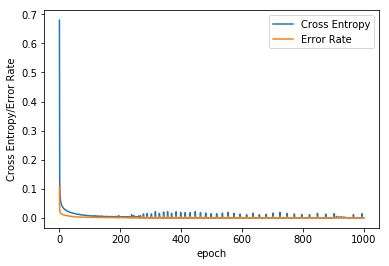

In [120]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！

plt.plot(np.arange(len(losses)), losses, label='Cross Entropy')
plt.plot(np.arange(len(errors)), errors, label='Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error Rate')
plt.legend()
plt.show()

In [122]:
net.eval()

# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = (start + batch_size) if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions, y)
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%' % (np.mean(errors)*100))

ValueError: Expected 4D tensor as input, got 2D tensor instead.

### 第四步：在测试集上测试模型

In [14]:
# 定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
# 取最大的那个元素的下标，与标签labels中的元素做比较
#def error_rate(predictions, labels):
#    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案"""
#    predictions = np.argmax(predictions, 1)
#    return 100.0 - (
#      100.0 *
#      np.sum( predictions == labels) /
#      predictions.shape[0])

In [65]:
# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = (start + batch_size) if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions, y)
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%' % (np.mean(errors)*100))

1 0.0203
2 0.0205632090762
3 0.0206280788177
4 0.0204866888519
5 0.0203414839798
6 0.020405982906
7 0.0202556325823
8 0.0203207381371
9 0.0200534759358
10 0.0200045207957
11 0.0192660550459
12 0.0190875232775
13 0.0189035916824
14 0.0188339731286
15 0.0185185185185
16 0.0186881188119
17 0.0183601609658
18 0.0180214723926
19 0.0176715176715
20 0.0173097251586
21 0.0172043010753
22 0.0170951859956
23 0.0169821826281
24 0.0167233560091
25 0.0168879907621
26 0.0169117647059
27 0.0170863309353
28 0.0172677261614
29 0.0166770573566
30 0.0165394402036
31 0.0154220779221
32 0.0150862068966
33 0.0149051490515
34 0.014716066482
35 0.0139872521246
36 0.0141304347826
37 0.0137240356083
38 0.013867781155
39 0.0134345794393
40 0.0129792332268
41 0.0133196721311
42 0.013468013468
43 0.013624567474
44 0.0137900355872
45 0.0141941391941
46 0.0134433962264
47 0.0133754863813
48 0.0122991967871
49 0.0124481327801
50 0.0126072961373
51 0.0127777777778
52 0.0129608294931
53 0.0110645933014
54 0.01088308457

### 用单个图像进行测试

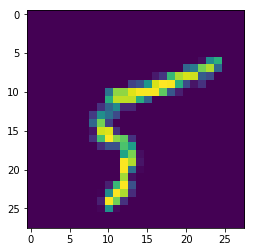

In [66]:
#随便从数据集中读入一张图片，并绘制出来
idx = np.random.randint(100)
muteimg = test_data[idx, 0, :, :]
plt.imshow(muteimg)

In [67]:
# 计算识别结果
x = Variable(torch.FloatTensor(test_X[idx, :].reshape(1, -1)))
predict = net(x)
np.argmax(predict.data.numpy())

5

## 升级版

如果你已经运行跑通上面的所有代码，那么请你尝试对其进行更改，让测试集上面的识别错误率进一步下降，看看能不能到1%以下

提示：可以考虑增加层的深度

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码